## Convolutional Neural Network for Emotion Classification

In [1]:
from google.colab import auth
auth.authenticate_user()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d ananthu017/emotion-detection-fer
!unzip emotion-detection-fer.zip -d emotion_data

Streaming output truncated to the last 5000 lines.
  inflating: emotion_data/train/sad/im37.png  
  inflating: emotion_data/train/sad/im370.png  
  inflating: emotion_data/train/sad/im3700.png  
  inflating: emotion_data/train/sad/im3701.png  
  inflating: emotion_data/train/sad/im3702.png  
  inflating: emotion_data/train/sad/im3703.png  
  inflating: emotion_data/train/sad/im3704.png  
  inflating: emotion_data/train/sad/im3705.png  
  inflating: emotion_data/train/sad/im3706.png  
  inflating: emotion_data/train/sad/im3707.png  
  inflating: emotion_data/train/sad/im3708.png  
  inflating: emotion_data/train/sad/im3709.png  
  inflating: emotion_data/train/sad/im371.png  
  inflating: emotion_data/train/sad/im3710.png  
  inflating: emotion_data/train/sad/im3711.png  
  inflating: emotion_data/train/sad/im3712.png  
  inflating: emotion_data/train/sad/im3713.png  
  inflating: emotion_data/train/sad/im3714.png  
  inflating: emotion_data/train/sad/im3715.png  
  inflating: emotion_d

In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

# Paths
train_path = 'emotion_data/train'
val_path = 'emotion_data/test'

# Transformations
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset_full = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset_full = datasets.ImageFolder(root=val_path, transform=transform)

# Print class-to-index mapping
print("Class to index mapping:", train_dataset_full.class_to_idx)

# Get index for 'happy' and 'sad'
class_to_idx = train_dataset_full.class_to_idx
happy_idx = class_to_idx['happy']
sad_idx = class_to_idx['sad']

# Filter only happy/sad
def filter_dataset(dataset, keep=[happy_idx, sad_idx]):
    indices = [i for i, (idx, label) in enumerate(dataset) if label in keep]
    return Subset(dataset, indices)

train_dataset = filter_dataset(train_dataset_full)
val_dataset = filter_dataset(val_dataset_full)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Class to index mapping: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


Class: happy


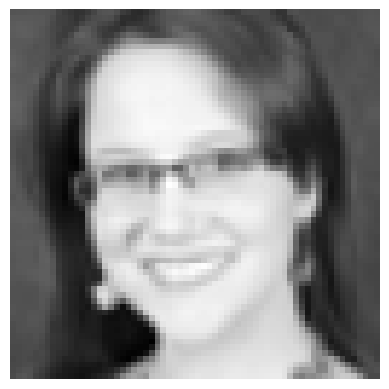

Class: sad


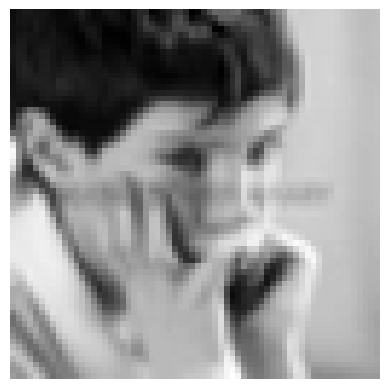

In [11]:
# Helper to unnormalize and display images
def imshow(img_tensor):
    img = img_tensor.numpy().squeeze()  # for grayscale
    img = img * 0.5 + 0.5  # unnormalize
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

# Display one sample from each class
seen_classes = set()
for i in range(len(train_dataset)):
    img, label = train_dataset[i]
    if label not in seen_classes:
        class_name = "happy" if label == happy_idx else "sad"
        print(f"Class: {class_name}")
        imshow(img)
        seen_classes.add(label)
    if len(seen_classes) == 2:
        break


So, the images are 64x64 pixels, grayscaled, and normalized. They form a tensor with dimensions [1, 64, 64] which correspond to [label, height, width].

Now we can move to creating our convolutional neural network. We will have:   

- Input image:

$$
I \in \mathbb{R}^{H \times W}
$$

- Kernel:

$$
K \in \mathbb{R}^{k \times k}
$$

- Bias term:

$$
b \in \mathbb{R}
$$

- Output feature map:

$$
O \in \mathbb{R}^{(H-k+1) \times (W-k+1)}
$$


The convolution operation at position (i, j) is:

$$
O(i, j) = B_{i} + \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} I(i + m, j + n) \cdot K(m, n)
$$

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Now, we will be creating a custom CNN class

class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()

        # Convolutional layer 1: We are taking the image as input and giving 16 features as output
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, bias=True)

        # Convolutional layer 2: 16 input features and 32 output
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, bias=True)

        # Max pooling: 2x2 reduces H and W by half
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # After two 2x2 poolings, 64x64 gets converted to 16x16
        # Final feature map size: (32 channels, 16, 16)
        # Flattened size: 32*16*16 = 8192
        self.fc1 = nn.Linear(32 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):

        # Reducing size again by half
        x = self.pool(F.relu(self.conv1(x)))

        x = self.pool(F.relu(self.conv2(x)))

        # Reshaping the 3D tensor into a 1D vector so it can go into a fully connected layer
        x = torch.flatten(x, 1)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary output

        return x


Since this is a binary classification, we will be using "Binary Cross-Entropy Loss" It is defined as follow:  
Given,
- True Label:
$$
y \in \{0,1\}
$$
- Predicted Label:
$$
\hat{y} \in \{0,1\}
$$

Then the binary cross-entropy loss is defined as:

$$
\text{BCE}(y, \hat{y}) = - \left( y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \right)
$$

- Basically. the closer $ \hat{y} $ is to $ y $, the lower the loss.

To compute the gradient of loss function ($ L $) with respect to our input, weights (which is kernel in our case), and biases, we calculate partial derivatives of loss function w.r.t. those.  
- $ \frac{\partial L}{\partial K} $  
  
- $ \frac{\partial L}{\partial B} $  
  
- $ \frac{\partial L}{\partial I} $  
  
Below is the gradient w.r.t. loss function:  
$$
\frac{\partial L}{\partial y} = -\biggr(\frac{y}{\hat{y}} - \frac{1-y}{1-\hat{y}}\biggl)
$$

Where:
- $ z = Wx + b $
- $ \hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}} $  
  
  
Once gradients are computed:

$$
\theta := \theta - \eta \cdot \frac{\partial L}{\partial \theta}
$$

Where:
- \$ \theta \$ is any trainable parameter (e.g., weights, biases)
- \$ \eta \$ is the learning rate

In [14]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Since I am using Google Colab, I have an option to use gpu
model = EmotionCNN().to(device)

criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # We have to convert labels into float so that we can put it into BCELoss
        labels = (labels == class_to_idx['sad']).float().unsqueeze(1)

        # Forward pass
        outputs = model(images)

        # Loss
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()             # Computing gradients (dL/dW)
        optimizer.step()            # Updating weights (gradient descent)

        # Saving loss
        running_loss += loss.item()

        predicted = (outputs > 0.5).float()  # Binary threshold at 0.5
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)

    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {acc:.2f}%")


Epoch 1: Loss = 0.5774, Accuracy = 69.51%
Epoch 2: Loss = 0.4748, Accuracy = 76.23%
Epoch 3: Loss = 0.4132, Accuracy = 80.27%
Epoch 4: Loss = 0.3656, Accuracy = 82.83%
Epoch 5: Loss = 0.3102, Accuracy = 85.98%


We can see that throughout the epochs, the loss has decreased and the accuracy has increased, which is an indicator that our model is working well. Now we can evaluate our model on test set.

In [15]:
model.eval()

correct = 0
total = 0

with torch.no_grad():  # Since we don't need gradients while testing, we can turn it off
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Converting sad/happy labels to binary labels (like 0 and 1)
        labels = (labels == class_to_idx['sad']).float().unsqueeze(1)

        outputs = model(images)   # Forward pass
        predictions = (outputs > 0.5).float()  # Converting probabilities to class labels

        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 80.04%


The model is performing very well overall.  
NOTE: Just by looking at the accuracy, we cannot fully evaluate the model performance.

### Generative AI used:  
Google Gemini (Already built in Google Colab)